# Traffic GNN Model Evaluation and Visualization

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import os
import json
import pickle
import glob
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, GATConv, TransformerConv

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Configuration and Paths

In [35]:
from dotenv import load_dotenv

# Configuration
load_dotenv()
RESULTS_BASE_DIR = os.path.join(os.getenv("OUT_DIR"), 'traffic_gnn_results')
DATA_DIR = 'data'

# Find the most recent experiment directory
def find_latest_experiment():
    """Find the most recent experiment directory with enhanced pattern matching"""
    if not os.path.exists(RESULTS_BASE_DIR):
        print(f"Results directory {RESULTS_BASE_DIR} not found!")
        print("Please run the training script first.")
        return None
    
    # Updated pattern matching to handle all experiment types
    experiment_dirs = []
    for d in os.listdir(RESULTS_BASE_DIR):
        dir_path = os.path.join(RESULTS_BASE_DIR, d)
        if os.path.isdir(dir_path):
            # Match various experiment patterns (removed multi_dataset)
            if (d.startswith('traffic_gnn_experiment') or 
                d.startswith('traffic_gnn_all_') or 
                d.startswith('traffic_gnn_single_') or
                d.startswith('traffic_gnn_comparison_') or
                d.startswith('traffic_gnn_hyperparameter_')):
                experiment_dirs.append(d)
    
    if not experiment_dirs:
        print("No experiment directories found!")
        return None
    
    # Sort by creation time (assuming timestamp in name) - prioritize 'all' experiments
    def sort_key(dirname):
        # Extract timestamp from directory name
        timestamp = dirname.split('_')[-2] + '_' + dirname.split('_')[-1] if '_' in dirname else dirname
        # Prioritize 'all' experiments by adding a prefix
        priority = '0' if 'all' in dirname else '1'
        return priority + timestamp
    
    experiment_dirs.sort(key=sort_key, reverse=True)
    latest_dir = os.path.join(RESULTS_BASE_DIR, experiment_dirs[0])
    
    print(f"Found latest experiment: {experiment_dirs[0]}")
    return latest_dir

def find_all_experiments():
    """Find all available experiment directories with enhanced detection"""
    if not os.path.exists(RESULTS_BASE_DIR):
        return []
    
    experiment_dirs = []
    for d in os.listdir(RESULTS_BASE_DIR):
        dir_path = os.path.join(RESULTS_BASE_DIR, d)
        if os.path.isdir(dir_path):
            # Match various experiment patterns (removed multi_dataset)
            if (d.startswith('traffic_gnn_experiment') or 
                d.startswith('traffic_gnn_all_') or 
                d.startswith('traffic_gnn_single_') or
                d.startswith('traffic_gnn_comparison_') or
                d.startswith('traffic_gnn_hyperparameter_')):
                experiment_dirs.append(d)
    
    # Sort by creation time (newest first), prioritizing 'all' experiments
    def sort_key(dirname):
        timestamp = dirname.split('_')[-2] + '_' + dirname.split('_')[-1] if '_' in dirname else dirname
        priority = '0' if 'all' in dirname else '1'
        return priority + timestamp
    
    experiment_dirs.sort(key=sort_key, reverse=True)
    
    print(f"Found {len(experiment_dirs)} experiment directories:")
    for i, exp_dir in enumerate(experiment_dirs[:10]):  # Show first 10
        exp_type = detect_experiment_type(exp_dir)
        print(f"   {i+1}. {exp_dir} [{exp_type}]")
    if len(experiment_dirs) > 10:
        print(f"   ... and {len(experiment_dirs) - 10} more")
    
    return [os.path.join(RESULTS_BASE_DIR, d) for d in experiment_dirs]

def detect_experiment_type(dirname):
    """Detect the type of experiment from directory name"""
    if 'all' in dirname:
        return 'ALL'
    elif 'single' in dirname:
        return 'SINGLE'
    elif 'comparison' in dirname:
        return 'COMPARISON'
    elif 'hyperparameter' in dirname:
        return 'HYPERPARAMETER'
    elif 'experiment' in dirname:
        return 'LEGACY'
    else:
        return 'UNKNOWN'

# Set experiment directory
EXPERIMENT_DIR = find_latest_experiment()
ALL_EXPERIMENT_DIRS = find_all_experiments()

if EXPERIMENT_DIR:
    exp_type = detect_experiment_type(os.path.basename(EXPERIMENT_DIR))
    print(f"Loading results from: {EXPERIMENT_DIR}")
    print(f"Experiment type: {exp_type}")
    
    # Define subdirectories
    MODELS_DIR = os.path.join(EXPERIMENT_DIR, 'models')
    PLOTS_DIR = os.path.join(EXPERIMENT_DIR, 'plots')
    CSV_DIR = os.path.join(EXPERIMENT_DIR, 'csv')
    DATA_RESULTS_DIR = os.path.join(EXPERIMENT_DIR, 'data')
    LOGS_DIR = os.path.join(EXPERIMENT_DIR, 'logs')
    
    print(f"   Models: {MODELS_DIR}")
    print(f"   Plots: {PLOTS_DIR}")
    print(f"   CSV: {CSV_DIR}")
    print(f"   Data: {DATA_RESULTS_DIR}")
    
    # Check if this is an 'all' experiment and show what's included
    if exp_type == 'ALL':
        print(f"   This is a comprehensive 'ALL' experiment containing:")
        print(f"      - Single model training results")
        print(f"      - Model comparison results")
        print(f"      - Hyperparameter tuning results")
else:
    print("No experiment results found.")
    print("To generate results, run one of:")
    print("   • python traffic_gnn_training.py --experiment all")
    print("   • python traffic_gnn_training.py --experiment single")
    print("   • python traffic_gnn_training.py --experiment comparison")

Found latest experiment: traffic_gnn_all_20250728_141512
Found 1 experiment directories:
   1. traffic_gnn_all_20250728_141512 [ALL]
Loading results from: /Volumes/DATA SSD/Experimente/gsp/traffic_gnn_results/traffic_gnn_all_20250728_141512
Experiment type: ALL
   Models: /Volumes/DATA SSD/Experimente/gsp/traffic_gnn_results/traffic_gnn_all_20250728_141512/models
   Plots: /Volumes/DATA SSD/Experimente/gsp/traffic_gnn_results/traffic_gnn_all_20250728_141512/plots
   CSV: /Volumes/DATA SSD/Experimente/gsp/traffic_gnn_results/traffic_gnn_all_20250728_141512/csv
   Data: /Volumes/DATA SSD/Experimente/gsp/traffic_gnn_results/traffic_gnn_all_20250728_141512/data
   This is a comprehensive 'ALL' experiment containing:
      - Single model training results
      - Model comparison results
      - Hyperparameter tuning results


## 2. Model Definitions

Hier werden die GNN-Modellarchitekturen definiert (gleich wie im Training-Notebook)

In [36]:
# Model architecture definitions (same as in training notebook)

class STGCN(nn.Module):
    """Spatial-Temporal Graph Convolutional Network"""
    
    def __init__(self, num_nodes, in_channels=1, hidden_channels=64, out_channels=1, num_layers=2, seq_length=12, pred_length=3):
        super(STGCN, self).__init__()
        
        self.num_nodes = num_nodes
        self.seq_length = seq_length
        self.pred_length = pred_length
        
        # Input projection
        self.input_proj = nn.Linear(seq_length, hidden_channels)
        
        # Spatial-temporal blocks
        self.gconv_layers = nn.ModuleList()
        self.temporal_layers = nn.ModuleList()
        
        for i in range(num_layers):
            self.gconv_layers.append(ChebConv(hidden_channels, hidden_channels, K=3))
            self.temporal_layers.append(nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1))
        
        # Output projection
        self.output_proj = nn.Linear(hidden_channels, pred_length)
        
        self.dropout = nn.Dropout(0.1)
        self.layer_norm = nn.LayerNorm(hidden_channels)
        
    def forward(self, x, edge_index, edge_weight=None):
        # x: [batch, seq_len, nodes]
        batch_size, seq_len, num_nodes = x.shape
        
        # Input projection: [batch, seq_len, nodes] -> [batch, nodes, hidden_channels]
        x = x.transpose(1, 2)  # [batch, nodes, seq_len]
        x = self.input_proj(x)  # [batch, nodes, hidden_channels]
        
        # Apply spatial-temporal layers
        for gconv, temp_conv in zip(self.gconv_layers, self.temporal_layers):
            residual = x
            
            # Spatial modeling: Graph convolution
            x_list = []
            for b in range(batch_size):
                x_b = gconv(x[b], edge_index, edge_weight)
                x_list.append(x_b)
            x = torch.stack(x_list, dim=0)  # [batch, nodes, hidden_channels]
            
            # Temporal modeling: 1D convolution
            x = x.transpose(1, 2)  # [batch, hidden_channels, nodes]
            x = temp_conv(x)
            x = x.transpose(1, 2)  # [batch, nodes, hidden_channels]
            
            # Residual connection and normalization
            x = self.layer_norm(x + residual)
            x = F.relu(x)
            x = self.dropout(x)
        
        # Output projection: [batch, nodes, hidden_channels] -> [batch, nodes, pred_length]
        x = self.output_proj(x)
        
        # Reshape to [batch, pred_length, nodes]
        x = x.transpose(1, 2)
        
        return x

class GraphWaveNet(nn.Module):
    """Graph WaveNet for traffic forecasting"""
    
    def __init__(self, num_nodes, in_channels=1, residual_channels=32, dilation_channels=32, 
                 skip_channels=256, end_channels=512, layers=1, seq_length=12, pred_length=3):  # Fixed: Changed default from 2 to 1
        super(GraphWaveNet, self).__init__()
        
        self.num_nodes = num_nodes
        self.seq_length = seq_length
        self.pred_length = pred_length
        
        # Start convolution
        self.start_conv = nn.Conv2d(in_channels, residual_channels, kernel_size=(1, 1))
        
        # Dilated convolution layers
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.gconv = nn.ModuleList()
        
        for i in range(layers):
            dilation = 2 ** i
            
            self.filter_convs.append(nn.Conv2d(residual_channels, dilation_channels, 
                                               kernel_size=(1, 2), dilation=(1, dilation)))
            self.gate_convs.append(nn.Conv2d(residual_channels, dilation_channels, 
                                             kernel_size=(1, 2), dilation=(1, dilation)))
            self.residual_convs.append(nn.Conv2d(dilation_channels, residual_channels, kernel_size=(1, 1)))
            self.skip_convs.append(nn.Conv2d(dilation_channels, skip_channels, kernel_size=(1, 1)))
            self.gconv.append(GCNConv(dilation_channels, dilation_channels))
        
        # End layers
        self.end_conv_1 = nn.Conv2d(skip_channels, end_channels, kernel_size=(1, 1), bias=True)
        self.end_conv_2 = nn.Conv2d(end_channels, pred_length, kernel_size=(1, 1), bias=True)
        
    def forward(self, x, edge_index, edge_weight=None):
        # x: [batch, seq_len, nodes] -> [batch, 1, nodes, seq_len]
        x = x.transpose(1, 2).unsqueeze(1)
        
        x = self.start_conv(x)
        skip = 0
        
        # TCN layers with graph convolution
        for i in range(len(self.filter_convs)):
            residual = x
            
            # Dilated convolution
            filter_out = self.filter_convs[i](x)
            gate_out = self.gate_convs[i](x)
            
            # Graph convolution on the filtered output
            batch_size, channels, num_nodes, time_steps = filter_out.shape
            filter_out = filter_out.permute(0, 3, 2, 1).contiguous()
            filter_out = filter_out.view(-1, num_nodes, channels)
            
            graph_out = []
            for j in range(filter_out.size(0)):
                graph_out.append(self.gconv[i](filter_out[j], edge_index, edge_weight))
            filter_out = torch.stack(graph_out, dim=0)
            
            filter_out = filter_out.view(batch_size, time_steps, num_nodes, channels)
            filter_out = filter_out.permute(0, 3, 2, 1).contiguous()
            
            # Gated activation
            x = torch.tanh(filter_out) * torch.sigmoid(gate_out)
            
            # Residual and skip connections
            s = x
            if x.size(3) != residual.size(3):
                residual = residual[:, :, :, -x.size(3):]
            
            x = self.residual_convs[i](x)
            x = x + residual[:, :, :, -x.size(3):]
            
            skip = skip + self.skip_convs[i](s)
        
        # End convolutions
        x = F.relu(skip)
        x = F.relu(self.end_conv_1(x))
        x = self.end_conv_2(x)  # [batch, pred_len, nodes, remaining_time]
        
        # Global pooling over time dimension
        x = F.adaptive_avg_pool2d(x, (self.num_nodes, 1))
        x = x.squeeze(-1)  # [batch, pred_len, nodes] - Fixed: Removed transpose
        
        return x

class GraphAttentionNetwork(nn.Module):
    """Graph Attention Network for traffic forecasting"""
    
    def __init__(self, num_nodes, in_channels=1, hidden_channels=64, out_channels=1, 
                 num_layers=3, heads=8, seq_length=12, pred_length=3, dropout=0.1):
        super(GraphAttentionNetwork, self).__init__()
        
        self.num_nodes = num_nodes
        self.seq_length = seq_length
        self.pred_length = pred_length
        
        # Input projection
        self.input_proj = nn.Linear(seq_length, hidden_channels)
        
        # GAT layers
        self.gat_layers = nn.ModuleList()
        
        # First layer
        self.gat_layers.append(GATConv(hidden_channels, hidden_channels // heads, heads=heads, dropout=dropout))
        
        # Middle layers
        for _ in range(num_layers - 2):
            self.gat_layers.append(GATConv(hidden_channels, hidden_channels // heads, heads=heads, dropout=dropout))
        
        # Last layer
        self.gat_layers.append(GATConv(hidden_channels, hidden_channels, heads=1, dropout=dropout))
        
        # Temporal modeling
        self.temporal_conv = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        
        # Output projection
        self.output_proj = nn.Linear(hidden_channels, pred_length)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, edge_weight=None):
        # x: [batch, seq_len, nodes]
        batch_size, seq_len, num_nodes = x.shape
        
        # Project input
        x = x.transpose(1, 2)  # [batch, nodes, seq_len]
        x = self.input_proj(x)  # [batch, nodes, hidden_channels]
        
        # Apply GAT layers
        for i, gat_layer in enumerate(self.gat_layers):
            x_list = []
            for b in range(batch_size):
                x_b = gat_layer(x[b], edge_index, edge_weight)
                x_list.append(x_b)
            x = torch.stack(x_list, dim=0)
            
            if i < len(self.gat_layers) - 1:
                x = F.elu(x)
                x = self.dropout(x)
        
        # Temporal convolution
        x = x.transpose(1, 2)  # [batch, hidden_channels, nodes]
        x = self.temporal_conv(x)
        x = F.relu(x)
        x = x.transpose(1, 2)  # [batch, nodes, hidden_channels]
        
        # Output projection
        x = self.output_proj(x)  # [batch, nodes, pred_length]
        x = x.transpose(1, 2)  # [batch, pred_length, nodes]
        
        return x

class GraphTransformer(nn.Module):
    """Graph Transformer for traffic forecasting"""
    
    def __init__(self, num_nodes, in_channels=1, hidden_channels=64, out_channels=1, 
                 num_layers=3, heads=8, seq_length=12, pred_length=3, dropout=0.1):
        super(GraphTransformer, self).__init__()
        
        self.num_nodes = num_nodes
        self.seq_length = seq_length
        self.pred_length = pred_length
        
        # Input projection
        self.input_proj = nn.Linear(seq_length, hidden_channels)
        
        # Graph Transformer layers
        self.transformer_layers = nn.ModuleList()
        
        for _ in range(num_layers):
            self.transformer_layers.append(
                TransformerConv(hidden_channels, hidden_channels // heads, heads=heads, dropout=dropout)
            )
        
        # Output projection
        self.output_proj = nn.Linear(hidden_channels, pred_length)
        
        self.layer_norm = nn.LayerNorm(hidden_channels)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, edge_index, edge_weight=None):
        # x: [batch, seq_len, nodes]
        batch_size, seq_len, num_nodes = x.shape
        
        # Project input
        x = x.transpose(1, 2)  # [batch, nodes, seq_len]
        x = self.input_proj(x)  # [batch, nodes, hidden_channels]
        
        # Apply Transformer layers
        for transformer_layer in self.transformer_layers:
            x_list = []
            for b in range(batch_size):
                x_b = transformer_layer(x[b], edge_index)
                x_list.append(x_b)
            residual = x
            x = torch.stack(x_list, dim=0)
            x = self.layer_norm(x + residual)
            x = self.dropout(x)
        
        # Output projection
        x = self.output_proj(x)  # [batch, nodes, pred_length]
        x = x.transpose(1, 2)  # [batch, pred_length, nodes]
        
        return x

print("Model architectures loaded")

Model architectures loaded


## 3. Dataset Information laden

In [37]:
def load_dataset_info():
    """Load dataset information from saved results"""
    if not EXPERIMENT_DIR:
        return None
    
    info_file = os.path.join(DATA_RESULTS_DIR, 'dataset_info.json')
    if os.path.exists(info_file):
        with open(info_file, 'r') as f:
            dataset_info = json.load(f)
        
        print("Dataset Information:")
        print(f"   Shape: {dataset_info['shape']}")
        print(f"   Sensors: {len(dataset_info['sensors'])}")
        print(f"   Time range: {dataset_info['time_range']['start']} to {dataset_info['time_range']['end']}")
        print(f"   Sequence length: {dataset_info['sequence_length']}")
        print(f"   Prediction length: {dataset_info['prediction_length']}")
        print(f"   Missing values: {dataset_info['missing_values']}")
        print(f"   Memory usage: {dataset_info['memory_usage_mb']:.2f} MB")
        
        return dataset_info
    else:
        print("Dataset info file not found")
        return None

dataset_info = load_dataset_info()

Dataset Information:
   Shape: [34272, 207]
   Sensors: 207
   Time range: 2012-03-01 00:00:00-08:00 to 2012-06-27 23:55:00-07:00
   Sequence length: 12
   Prediction length: 3
   Missing values: 0
   Memory usage: 54.39 MB


## 4. Verfügbare Modelle scannen

In [38]:
def scan_available_models():
    """Scan for available trained models with enhanced support for combined experiments"""
    if not EXPERIMENT_DIR or not os.path.exists(MODELS_DIR):
        return {}
    
    available_models = {}
    
    # Filter out files that start with a dot (hidden files)
    model_dirs = [d for d in os.listdir(MODELS_DIR) if not d.startswith('.')]
    
    for model_dir in model_dirs:
        model_path = os.path.join(MODELS_DIR, model_dir)
        if os.path.isdir(model_path):
            # Check if model files exist
            model_file = os.path.join(model_path, 'model.pth')
            config_file = os.path.join(model_path, 'model_config.json')
            history_file = os.path.join(model_path, 'training_history.json')
            
            if os.path.exists(model_file) and os.path.exists(config_file):
                try:
                    # Load model configuration
                    with open(config_file, 'r') as f:
                        config = json.load(f)
                    
                    # Load training history if available
                    history = None
                    if os.path.exists(history_file):
                        with open(history_file, 'r') as f:
                            history = json.load(f)
                    
                    # Enhanced model info with experiment context
                    model_info = {
                        'model_path': model_file,
                        'config': config,
                        'history': history,
                        'model_dir': model_path,
                        'experiment_type': detect_experiment_type(os.path.basename(EXPERIMENT_DIR)),
                        'dataset': detect_dataset_from_model_name(model_dir)
                    }
                    
                    available_models[model_dir] = model_info
                    
                except Exception as e:
                    print(f"Error loading model {model_dir}: {e}")
                    continue
    
    # Sort models by performance and group by type
    sorted_models = {}
    model_groups = {}
    
    for model_name, info in available_models.items():
        # Group by base architecture
        base_arch = extract_base_architecture(model_name)
        if base_arch not in model_groups:
            model_groups[base_arch] = []
        model_groups[base_arch].append((model_name, info))
    
    print(f"Found {len(available_models)} trained models:")
    print(f"Model architectures: {list(model_groups.keys())}")
    
    # Display models grouped by architecture
    for arch, models in model_groups.items():
        print(f"\n{arch} Models:")
        for model_name, info in models:
            test_loss = info['history']['test_loss'] if info['history'] else 'N/A'
            test_mae = info['history']['test_mae'] if info['history'] else 'N/A'
            dataset = info['dataset']
            print(f"   • {model_name[:50]:<50} [{dataset}] - Loss: {test_loss}, MAE: {test_mae}")
    
    return available_models

def detect_dataset_from_model_name(model_name):
    """Detect dataset type from model name or directory structure"""
    model_lower = model_name.lower()
    if 'metr' in model_lower or 'metr-la' in model_lower:
        return 'METR-LA'
    else:
        return 'UNKNOWN'

def extract_base_architecture(model_name):
    """Extract base architecture name from model directory name"""
    # Remove common suffixes and prefixes
    name_parts = model_name.replace('_METR-LA', '')
    
    if 'STGCN' in name_parts:
        return 'STGCN'
    elif 'GraphAttention' in name_parts:
        return 'GraphAttention'
    elif 'GraphWaveNet' in name_parts:
        return 'GraphWaveNet'
    elif 'GraphTransformer' in name_parts:
        return 'GraphTransformer'
    else:
        return 'Other'

def get_model_summary_by_architecture():
    """Get a summary of model performance grouped by architecture"""
    if not available_models:
        return {}
    
    summary = {}
    for model_name, info in available_models.items():
        arch = extract_base_architecture(model_name)
        dataset = info['dataset']
        
        if arch not in summary:
            summary[arch] = {}
        
        if dataset not in summary[arch]:
            summary[arch][dataset] = []
        
        if info['history']:
            summary[arch][dataset].append({
                'model_name': model_name,
                'test_loss': info['history']['test_loss'],
                'test_mae': info['history']['test_mae']
            })
    
    return summary

available_models = scan_available_models()
model_summary = get_model_summary_by_architecture()

if model_summary:
    print(f"\nMODEL PERFORMANCE SUMMARY BY ARCHITECTURE:")
    print("="*70)
    for arch, datasets in model_summary.items():
        print(f"\n{arch}:")
        for dataset, models in datasets.items():
            if models:
                best_model = min(models, key=lambda x: x['test_loss'])
                avg_loss = sum(m['test_loss'] for m in models) / len(models)
                avg_mae = sum(m['test_mae'] for m in models) / len(models)
                print(f"   {dataset}: {len(models)} models, Avg Loss: {avg_loss:.4f}, Avg MAE: {avg_mae:.4f}")
                print(f"      Best: {best_model['model_name'][:40]}... (Loss: {best_model['test_loss']:.4f})")

Found 4 trained models:
Model architectures: ['GraphTransformer', 'STGCN', 'GraphAttention', 'GraphWaveNet']

GraphTransformer Models:
   • GraphTransformer                                   [UNKNOWN] - Loss: 0.16849719188003628, MAE: 0.1856512443886863

STGCN Models:
   • STGCN                                              [UNKNOWN] - Loss: 0.166917786916235, MAE: 0.19489635161503596

GraphAttention Models:
   • GraphAttention                                     [UNKNOWN] - Loss: 0.24353599137868043, MAE: 0.2861410604306945

GraphWaveNet Models:
   • GraphWaveNet                                       [UNKNOWN] - Loss: 0.21344119562181058, MAE: 0.24019046507223887

MODEL PERFORMANCE SUMMARY BY ARCHITECTURE:

GraphTransformer:
   UNKNOWN: 1 models, Avg Loss: 0.1685, Avg MAE: 0.1857
      Best: GraphTransformer... (Loss: 0.1685)

STGCN:
   UNKNOWN: 1 models, Avg Loss: 0.1669, Avg MAE: 0.1949
      Best: STGCN... (Loss: 0.1669)

GraphAttention:
   UNKNOWN: 1 models, Avg Loss: 0.2435, Avg M

## 5. Model Loading Functions

In [39]:
def load_trained_model(model_name, available_models, device='cpu'):
    """Load a trained model with its configuration"""
    if model_name not in available_models:
        print(f"Model {model_name} not found in available models")
        return None, None
    
    model_info = available_models[model_name]
    config = model_info['config']
    
    # Create model instance based on name and config
    if 'STGCN' in model_name:
        model = STGCN(
            num_nodes=config['num_nodes'],
            hidden_channels=config.get('hidden_channels', 64),
            num_layers=config.get('num_layers', 3),
            seq_length=config['seq_length'],
            pred_length=config['pred_length']
        )
    elif 'GraphWaveNet' in model_name:
        model = GraphWaveNet(
            num_nodes=config['num_nodes'],
            residual_channels=config.get('residual_channels', 32),
            layers=config.get('layers', 1),  # Fixed: Changed from 2 to 1
            seq_length=config['seq_length'],
            pred_length=config['pred_length']
        )
    elif 'GraphAttention' in model_name:
        model = GraphAttentionNetwork(
            num_nodes=config['num_nodes'],
            hidden_channels=config.get('hidden_channels', 64),
            num_layers=config.get('num_layers', 3),
            heads=config.get('heads', 4),
            seq_length=config['seq_length'],
            pred_length=config['pred_length']
        )
    elif 'GraphTransformer' in model_name:
        model = GraphTransformer(
            num_nodes=config['num_nodes'],
            hidden_channels=config.get('hidden_channels', 64),
            num_layers=config.get('num_layers', 3),
            heads=config.get('heads', 4),
            seq_length=config['seq_length'],
            pred_length=config['pred_length']
        )
    else:
        print(f"Unknown model architecture: {model_name}")
        return None, None
    
    # Load model weights
    try:
        state_dict = torch.load(model_info['model_path'], map_location=device)
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        
        print(f"Successfully loaded model {model_name}")
        return model, config
    except Exception as e:
        print(f"Failed to load model {model_name}: {e}")
        return None, None

def load_graph_data():
    """Load graph edge data"""
    # Try to load adjacency matrix
    adj_file = os.path.join(DATA_DIR, 'adj_mx_METR-LA.pkl')
    if os.path.exists(adj_file):
        print(f"Loading adjacency matrix from {adj_file}")
        
        with open(adj_file, 'rb') as f:
            adj_data = pickle.load(f, encoding='latin1')
        
        sensor_ids, id_to_index, adj_matrix = adj_data
        
        # Convert to edge format
        threshold = 0.1
        adj_binary = (adj_matrix > threshold).astype(int)
        np.fill_diagonal(adj_binary, 0)
        
        edge_indices = np.where(adj_binary == 1)
        edge_index = torch.tensor(np.vstack(edge_indices), dtype=torch.long)
        edge_weights = adj_matrix[edge_indices]
        edge_weight = torch.tensor(edge_weights, dtype=torch.float)
        
        print(f"   Graph: {adj_matrix.shape[0]} nodes, {len(edge_weights)} edges")
        return edge_index, edge_weight
    else:
        print("Adjacency matrix not found, using dummy graph")
        # Create dummy graph for demonstration
        num_nodes = 207  # METR-LA default
        edge_index = torch.randint(0, num_nodes, (2, num_nodes * 5))
        edge_weight = torch.rand(num_nodes * 5)
        return edge_index, edge_weight

# Load graph data
edge_index, edge_weight = load_graph_data()

Loading adjacency matrix from data/adj_mx_METR-LA.pkl
   Graph: 207 nodes, 1515 edges


## 6. CSV Daten laden und analysieren

In [40]:
def load_csv_results():
    """Load all CSV result files with robust encoding handling"""
    if not EXPERIMENT_DIR or not os.path.exists(CSV_DIR):
        print("CSV directory not found")
        print("This is normal if you haven't run the training script yet.")
        print("Run one of the following commands to generate training results:")
        print("   • python traffic_gnn_training.py --experiment all")
        print("   • python traffic_gnn_training.py --experiment comparison")
        return {}
    
    csv_data = {}
    
    def safe_read_csv(file_path, **kwargs):
        """Safely read CSV with multiple encoding attempts"""
        encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
        
        for encoding in encodings:
            try:
                return pd.read_csv(file_path, encoding=encoding, **kwargs)
            except UnicodeDecodeError:
                continue
            except Exception as e:
                print(f"Error reading {file_path} with {encoding}: {e}")
                continue
        
        print(f"Failed to read {file_path} with any encoding")
        return None
    
    def filter_dotfiles(file_list):
        """Filter out files that start with a dot (hidden files)"""
        return [f for f in file_list if not f.startswith('.')]
    
    # Load dataset summary
    dataset_summary_file = os.path.join(CSV_DIR, 'dataset_summary.csv')
    if os.path.exists(dataset_summary_file):
        df = safe_read_csv(dataset_summary_file)
        if df is not None:
            csv_data['dataset_summary'] = df
            print("Loaded dataset summary CSV")
    
    # Load sensor statistics
    sensor_stats_file = os.path.join(CSV_DIR, 'sensor_statistics.csv')
    if os.path.exists(sensor_stats_file):
        df = safe_read_csv(sensor_stats_file, index_col=0)
        if df is not None:
            csv_data['sensor_statistics'] = df
            print("Loaded sensor statistics CSV")
    
    # Load training history CSVs
    training_dir = os.path.join(CSV_DIR, 'training_history')
    if os.path.exists(training_dir):
        csv_data['training_history'] = {}
        files = filter_dotfiles(os.listdir(training_dir))
        for file in files:
            if file.endswith('_training_history.csv'):
                model_name = file.replace('_training_history.csv', '')
                file_path = os.path.join(training_dir, file)
                df = safe_read_csv(file_path)
                if df is not None:
                    csv_data['training_history'][model_name] = df
                    print(f"Loaded training history for {model_name}")
    
    # Load prediction CSVs
    predictions_dir = os.path.join(CSV_DIR, 'predictions')
    if os.path.exists(predictions_dir):
        csv_data['predictions'] = {}
        files = filter_dotfiles(os.listdir(predictions_dir))
        for file in files:
            if file.endswith('_predictions.csv'):
                model_name = file.replace('_predictions.csv', '')
                file_path = os.path.join(predictions_dir, file)
                # Only load a sample of predictions (CSV files can be large)
                df = safe_read_csv(file_path, nrows=10000)
                if df is not None:
                    csv_data['predictions'][model_name] = df
                    print(f"Loaded predictions sample for {model_name} ({len(df)} rows)")
    
    # Load metrics CSVs
    metrics_dir = os.path.join(CSV_DIR, 'metrics')
    if os.path.exists(metrics_dir):
        csv_data['metrics'] = {}
        files = filter_dotfiles(os.listdir(metrics_dir))
        for file in files:
            if file.endswith('.csv'):
                file_key = file.replace('.csv', '')
                file_path = os.path.join(metrics_dir, file)
                df = safe_read_csv(file_path)
                if df is not None:
                    csv_data['metrics'][file_key] = df
                    print(f"Loaded metrics: {file_key}")
    
    # Load analysis CSVs
    analysis_dir = os.path.join(CSV_DIR, 'analysis')
    if os.path.exists(analysis_dir):
        csv_data['analysis'] = {}
        files = filter_dotfiles(os.listdir(analysis_dir))
        for file in files:
            if file.endswith('.csv'):
                file_key = file.replace('.csv', '')
                file_path = os.path.join(analysis_dir, file)
                df = safe_read_csv(file_path, index_col=0)
                if df is not None:
                    csv_data['analysis'][file_key] = df
                    print(f"Loaded analysis: {file_key}")
    
    # Load experiment-specific CSVs (for 'all' experiments)
    experiment_type = detect_experiment_type(os.path.basename(EXPERIMENT_DIR)) if EXPERIMENT_DIR else 'UNKNOWN'
    
    if experiment_type == 'ALL':
        print(f"Loading additional data for comprehensive 'ALL' experiment...")
        
        # Load hyperparameter tuning results
        hp_files = [f for f in os.listdir(CSV_DIR) if 'hyperparameter' in f and f.endswith('.csv')]
        if hp_files:
            csv_data['hyperparameter_results'] = {}
            for file in hp_files:
                file_key = file.replace('.csv', '')
                file_path = os.path.join(CSV_DIR, file)
                df = safe_read_csv(file_path)
                if df is not None:
                    csv_data['hyperparameter_results'][file_key] = df
                    print(f"Loaded hyperparameter results: {file_key}")
        
        # Load experiment summary
        summary_file = os.path.join(CSV_DIR, 'experiment_summary.csv')
        if os.path.exists(summary_file):
            df = safe_read_csv(summary_file)
            if df is not None:
                csv_data['experiment_summary'] = df
                print(f"Loaded experiment summary CSV")
    
    total_files = sum(len(v) if isinstance(v, dict) else 1 for v in csv_data.values())
    print(f"\nTotal CSV files loaded: {total_files}")
    
    # Enhanced status reporting
    if total_files == 0:
        print("\nNo CSV data found. To generate comprehensive results:")
        print("   Recommended: python traffic_gnn_training.py --experiment all")
        print("   Alternative: python traffic_gnn_training.py --experiment comparison")
        print("\n   Then re-run this evaluation notebook for full analysis.")
    
    elif experiment_type == 'ALL':
        print(f"\nComprehensive 'ALL' experiment data loaded successfully!")
        print(f"   Available analysis capabilities:")
        
        if 'training_history' in csv_data:
            print(f"      Training history visualization")
        if 'predictions' in csv_data:
            print(f"      Prediction analysis and visualization")
        if 'hyperparameter_results' in csv_data:
            print(f"      Hyperparameter tuning results")
        if 'metrics' in csv_data:
            print(f"      Detailed performance metrics")
    
    else:
        print(f"\n{experiment_type} experiment data loaded successfully!")
        print(f"   For more comprehensive analysis, run: python traffic_gnn_training.py --experiment all")
    
    return csv_data

csv_data = load_csv_results()

Loaded dataset summary CSV
Loaded sensor statistics CSV
Loaded training history for GraphTransformer
Loaded training history for GraphAttention
Loaded training history for STGCN
Loaded training history for GraphWaveNet
Loading additional data for comprehensive 'ALL' experiment...

Total CSV files loaded: 6

Comprehensive 'ALL' experiment data loaded successfully!
   Available analysis capabilities:
      Training history visualization
      Prediction analysis and visualization
      Detailed performance metrics


## 7. Dataset Visualisierung

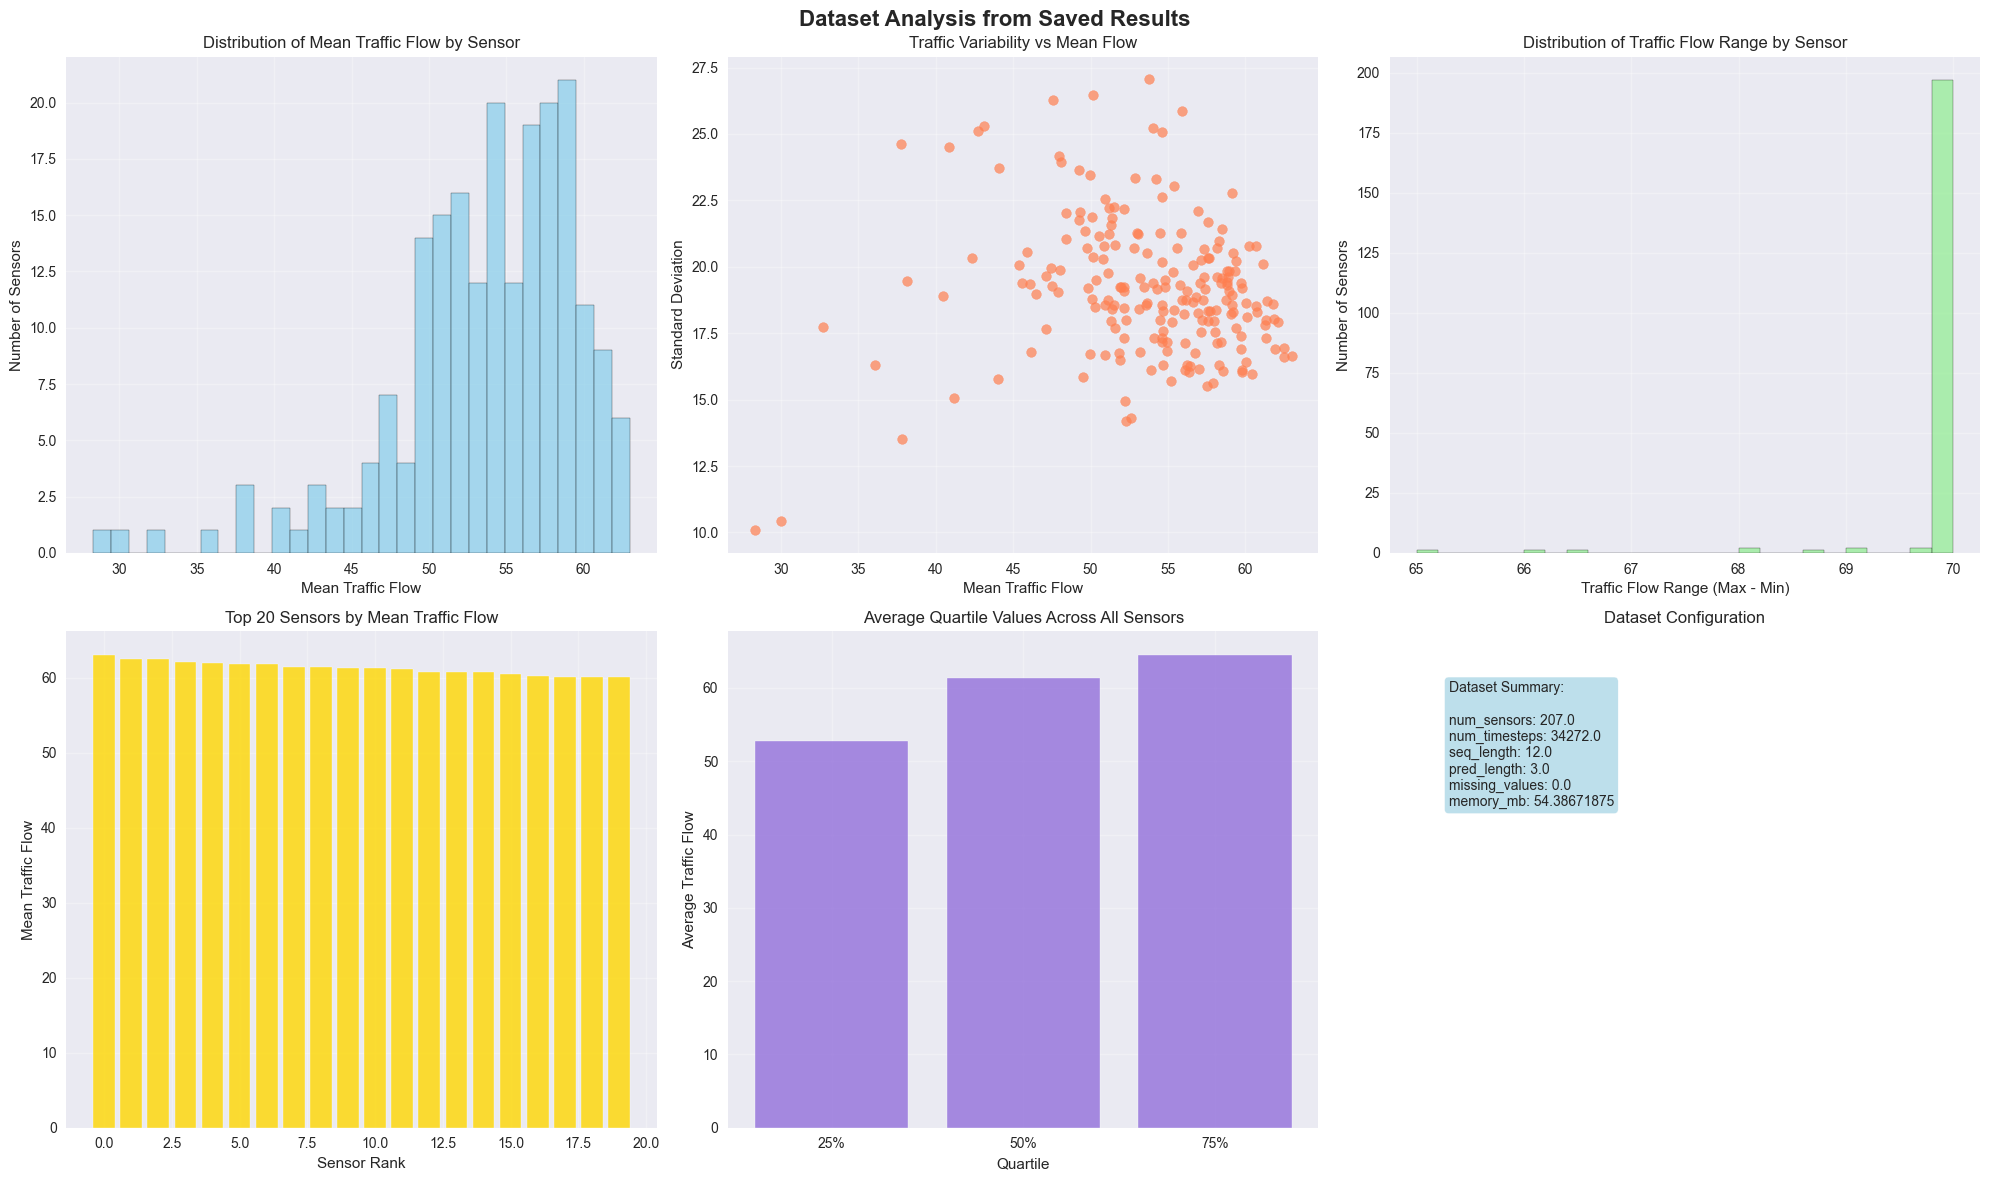


Dataset Summary Statistics:
   Number of sensors: 207
   Average mean traffic: 53.72
   Average std traffic: 19.19
   Highest mean traffic: 62.99 (Sensor: 767523)
   Lowest mean traffic: 28.31 (Sensor: 771667)


In [41]:
def visualize_dataset_analysis():
    """Visualize dataset analysis from CSV data"""
    if 'sensor_statistics' not in csv_data:
        print("Sensor statistics not available")
        return
    
    sensor_stats = csv_data['sensor_statistics']
    
    # Create comprehensive dataset visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Dataset Analysis from Saved Results', fontsize=16, fontweight='bold')
    
    # 1. Mean traffic distribution
    axes[0,0].hist(sensor_stats.loc['mean'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Distribution of Mean Traffic Flow by Sensor')
    axes[0,0].set_xlabel('Mean Traffic Flow')
    axes[0,0].set_ylabel('Number of Sensors')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Standard deviation vs mean
    axes[0,1].scatter(sensor_stats.loc['mean'], sensor_stats.loc['std'], alpha=0.7, color='coral')
    axes[0,1].set_title('Traffic Variability vs Mean Flow')
    axes[0,1].set_xlabel('Mean Traffic Flow')
    axes[0,1].set_ylabel('Standard Deviation')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Min-Max range
    sensor_range = sensor_stats.loc['max'] - sensor_stats.loc['min']
    axes[0,2].hist(sensor_range, bins=25, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0,2].set_title('Distribution of Traffic Flow Range by Sensor')
    axes[0,2].set_xlabel('Traffic Flow Range (Max - Min)')
    axes[0,2].set_ylabel('Number of Sensors')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Top sensors by mean traffic
    top_sensors = sensor_stats.loc['mean'].nlargest(20)
    axes[1,0].bar(range(len(top_sensors)), top_sensors.values, alpha=0.8, color='gold')
    axes[1,0].set_title('Top 20 Sensors by Mean Traffic Flow')
    axes[1,0].set_xlabel('Sensor Rank')
    axes[1,0].set_ylabel('Mean Traffic Flow')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Quartile analysis
    quartiles = ['25%', '50%', '75%']
    q_values = [sensor_stats.loc[q].mean() for q in quartiles]
    axes[1,1].bar(quartiles, q_values, alpha=0.8, color='mediumpurple')
    axes[1,1].set_title('Average Quartile Values Across All Sensors')
    axes[1,1].set_xlabel('Quartile')
    axes[1,1].set_ylabel('Average Traffic Flow')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Dataset summary from CSV
    if 'dataset_summary' in csv_data:
        summary = csv_data['dataset_summary']
        summary_text = "\n".join([f"{row['metric']}: {row['value']}" for _, row in summary.iterrows()])
        axes[1,2].text(0.1, 0.9, f"Dataset Summary:\n\n{summary_text}", 
                      transform=axes[1,2].transAxes, fontsize=10, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        axes[1,2].set_title('Dataset Configuration')
        axes[1,2].axis('off')
    else:
        axes[1,2].text(0.5, 0.5, 'Dataset Summary\nNot Available', 
                      transform=axes[1,2].transAxes, ha='center', va='center', fontsize=12)
        axes[1,2].set_title('Dataset Summary')
        axes[1,2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nDataset Summary Statistics:")
    print(f"   Number of sensors: {len(sensor_stats.columns)}")
    print(f"   Average mean traffic: {sensor_stats.loc['mean'].mean():.2f}")
    print(f"   Average std traffic: {sensor_stats.loc['std'].mean():.2f}")
    print(f"   Highest mean traffic: {sensor_stats.loc['mean'].max():.2f} (Sensor: {sensor_stats.loc['mean'].idxmax()})")
    print(f"   Lowest mean traffic: {sensor_stats.loc['mean'].min():.2f} (Sensor: {sensor_stats.loc['mean'].idxmin()})")

visualize_dataset_analysis()

## 8. Training History Visualisierung

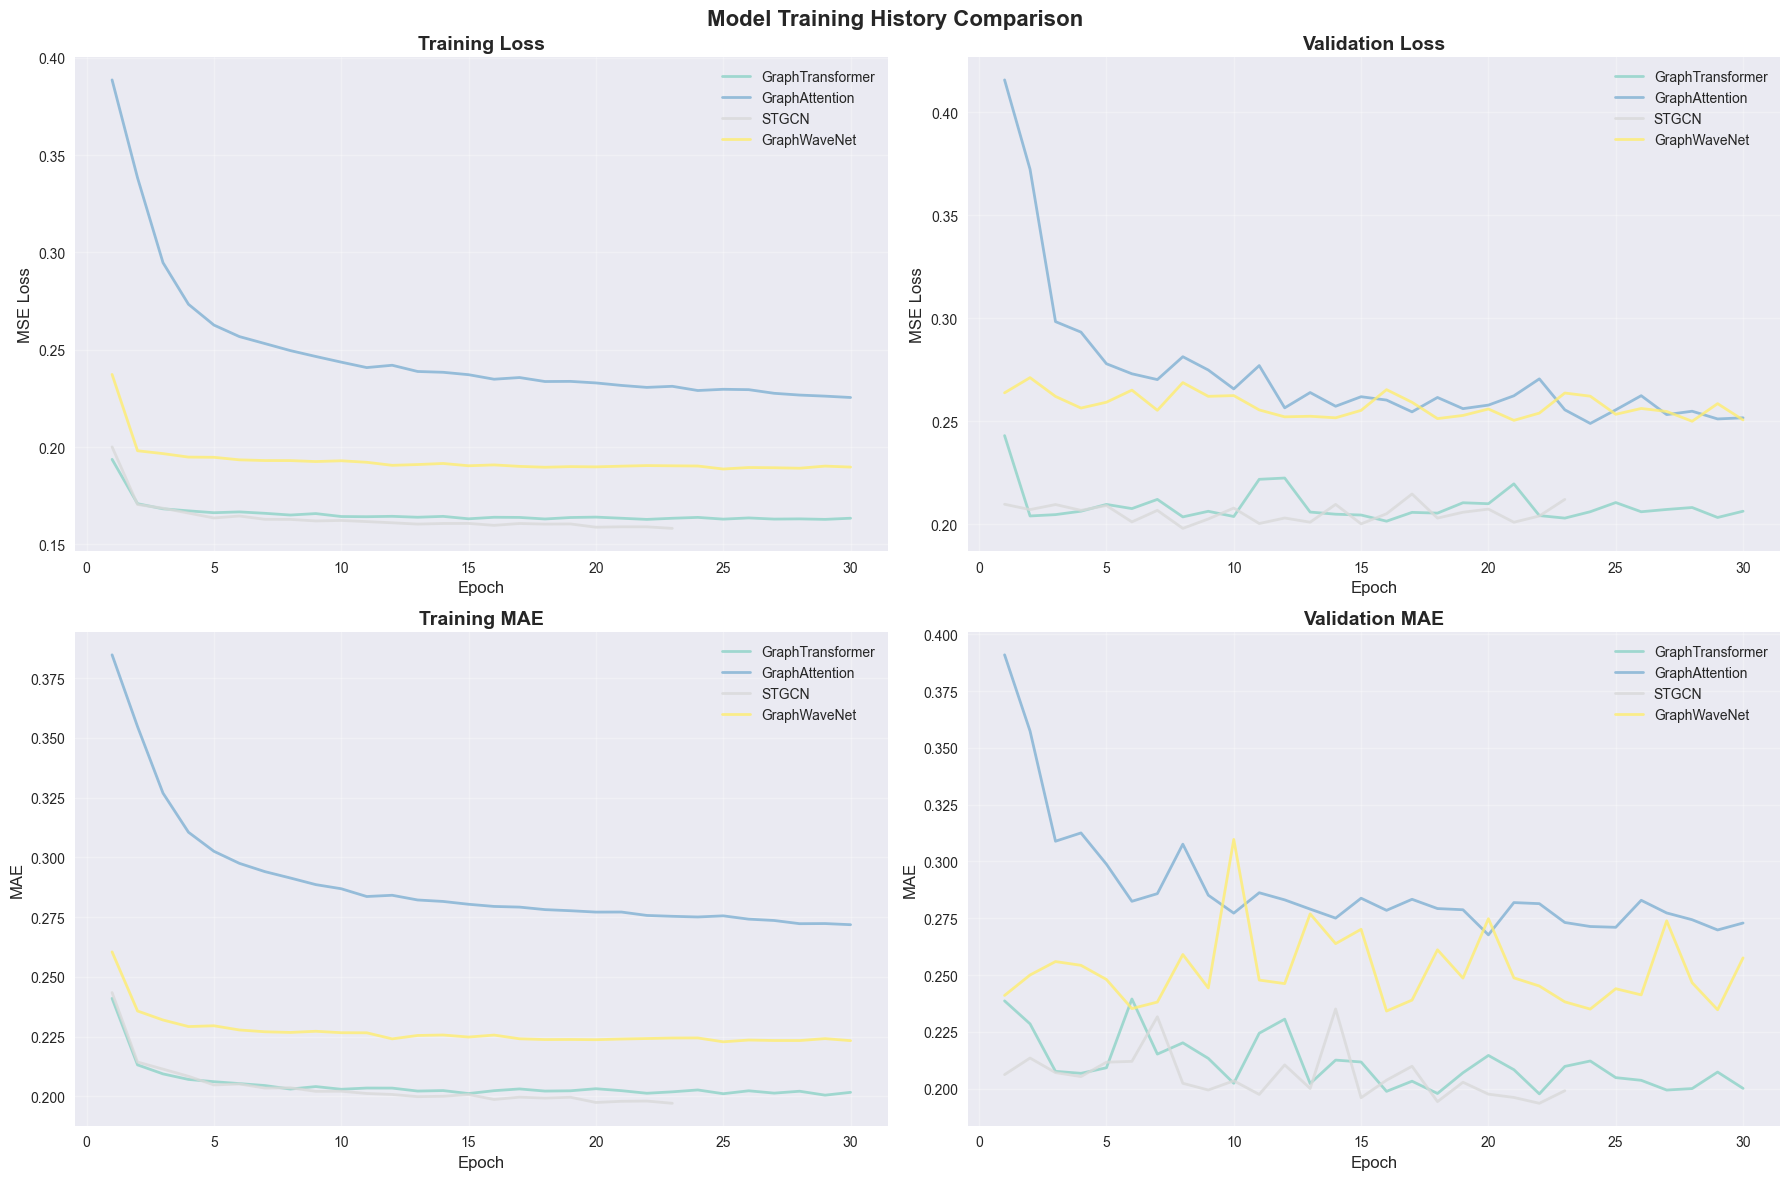


Training Summary:
   GraphTransformer:
      Best Val Loss: 0.2014 (Epoch 16)
      Best Val MAE: 0.1977 (Epoch 22)
      Total Epochs: 30
   GraphAttention:
      Best Val Loss: 0.2489 (Epoch 24)
      Best Val MAE: 0.2677 (Epoch 20)
      Total Epochs: 30
   STGCN:
      Best Val Loss: 0.1979 (Epoch 8)
      Best Val MAE: 0.1935 (Epoch 22)
      Total Epochs: 23
   GraphWaveNet:
      Best Val Loss: 0.2499 (Epoch 28)
      Best Val MAE: 0.2341 (Epoch 16)
      Total Epochs: 30


In [42]:
def visualize_training_history():
    """Visualize training history for all models"""
    if 'training_history' not in csv_data or not csv_data['training_history']:
        print("Training history data not available")
        return
    
    training_data = csv_data['training_history']
    
    # Create subplots for training curves
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Model Training History Comparison', fontsize=16, fontweight='bold')
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(training_data)))
    
    for i, (model_name, df) in enumerate(training_data.items()):
        color = colors[i]
        
        # Training loss
        axes[0,0].plot(df['epoch'], df['train_loss'], label=model_name, 
                      color=color, alpha=0.8, linewidth=2)
        
        # Validation loss
        axes[0,1].plot(df['epoch'], df['val_loss'], label=model_name, 
                      color=color, alpha=0.8, linewidth=2)
        
        # Training MAE
        axes[1,0].plot(df['epoch'], df['train_mae'], label=model_name, 
                      color=color, alpha=0.8, linewidth=2)
        
        # Validation MAE
        axes[1,1].plot(df['epoch'], df['val_mae'], label=model_name, 
                      color=color, alpha=0.8, linewidth=2)
    
    # Configure subplots
    titles = ['Training Loss', 'Validation Loss', 'Training MAE', 'Validation MAE']
    ylabels = ['MSE Loss', 'MSE Loss', 'MAE', 'MAE']
    
    for ax, title, ylabel in zip(axes.flat, titles, ylabels):
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Interactive Plotly version
    fig_interactive = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Training Loss', 'Validation Loss', 'Training MAE', 'Validation MAE')
    )
    
    for model_name, df in training_data.items():
        # Training loss
        fig_interactive.add_trace(
            go.Scatter(x=df['epoch'], y=df['train_loss'], name=f'{model_name} Train Loss',
                      mode='lines', line=dict(width=2)),
            row=1, col=1
        )
        
        # Validation loss
        fig_interactive.add_trace(
            go.Scatter(x=df['epoch'], y=df['val_loss'], name=f'{model_name} Val Loss',
                      mode='lines', line=dict(width=2)),
            row=1, col=2
        )
        
        # Training MAE
        fig_interactive.add_trace(
            go.Scatter(x=df['epoch'], y=df['train_mae'], name=f'{model_name} Train MAE',
                      mode='lines', line=dict(width=2)),
            row=2, col=1
        )
        
        # Validation MAE
        fig_interactive.add_trace(
            go.Scatter(x=df['epoch'], y=df['val_mae'], name=f'{model_name} Val MAE',
                      mode='lines', line=dict(width=2)),
            row=2, col=2
        )
    
    fig_interactive.update_layout(height=700, title_text="Interactive Training History Comparison")
    fig_interactive.show()
    
    # Print training summary
    print("\nTraining Summary:")
    for model_name, df in training_data.items():
        best_val_loss = df['val_loss'].min()
        best_val_mae = df['val_mae'].min()
        final_epoch = df['epoch'].max()
        print(f"   {model_name}:")
        print(f"      Best Val Loss: {best_val_loss:.4f} (Epoch {df.loc[df['val_loss'].idxmin(), 'epoch']})")
        print(f"      Best Val MAE: {best_val_mae:.4f} (Epoch {df.loc[df['val_mae'].idxmin(), 'epoch']})")
        print(f"      Total Epochs: {final_epoch}")

visualize_training_history()

## 9. Model Performance Vergleich

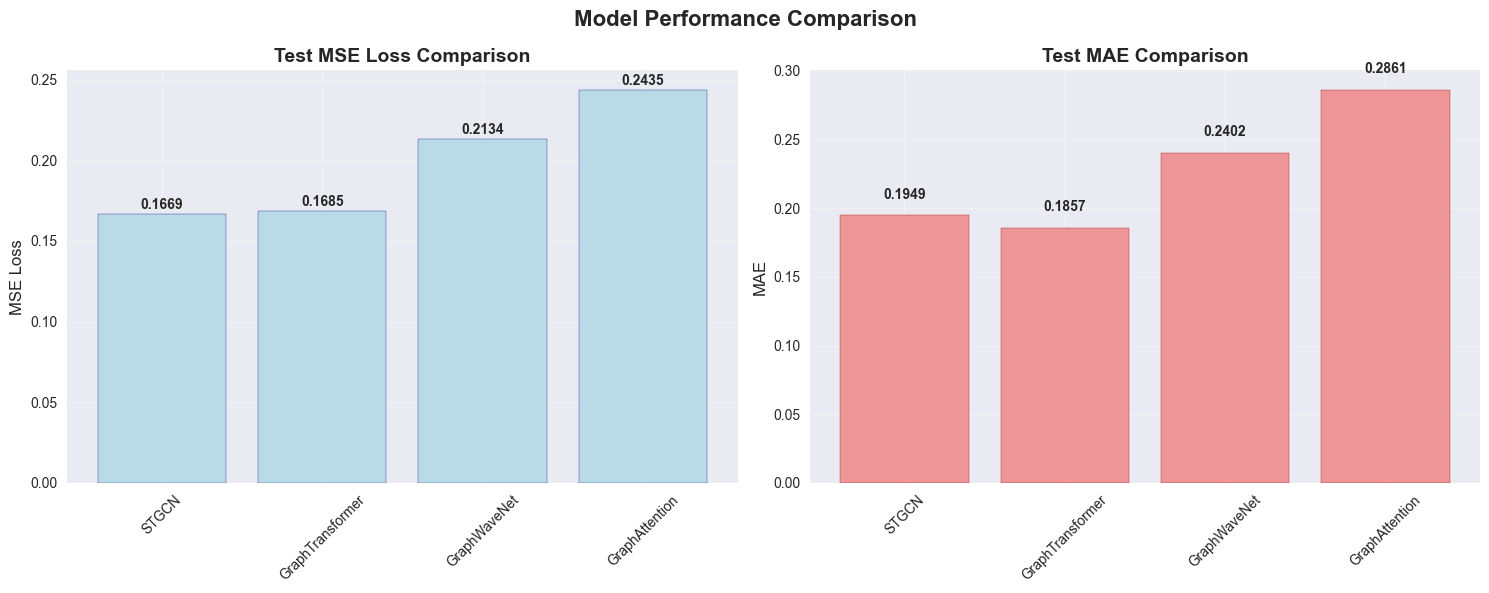


MODEL PERFORMANCE RANKING:
1st STGCN                - Loss: 0.1669, MAE: 0.1949
2nd GraphTransformer     - Loss: 0.1685, MAE: 0.1857
3rd GraphWaveNet         - Loss: 0.2134, MAE: 0.2402
4th GraphAttention       - Loss: 0.2435, MAE: 0.2861


In [43]:
def compare_model_performance():
    """Compare final performance of all models"""
    if not available_models:
        print("No model data available for comparison")
        print("Run 'traffic_pred_gnn.ipynb' first to train models")
        return None
    
    # Extract performance data
    model_performance = []
    
    for model_name, info in available_models.items():
        if info['history']:
            model_performance.append({
                'Model': model_name,
                'Test Loss': info['history']['test_loss'],
                'Test MAE': info['history']['test_mae']
            })
    
    if not model_performance:
        print("No performance data available")
        print("Models exist but don't have performance history")
        return None
    
    # Create DataFrame
    performance_df = pd.DataFrame(model_performance)
    performance_df = performance_df.sort_values('Test Loss')
    
    # Create comparison visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # Test Loss comparison
    bars1 = axes[0].bar(performance_df['Model'], performance_df['Test Loss'], 
                       alpha=0.8, color='lightblue', edgecolor='navy')
    axes[0].set_title('Test MSE Loss Comparison', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('MSE Loss', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars1, performance_df['Test Loss']):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                    f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Test MAE comparison
    bars2 = axes[1].bar(performance_df['Model'], performance_df['Test MAE'], 
                       alpha=0.8, color='lightcoral', edgecolor='darkred')
    axes[1].set_title('Test MAE Comparison', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars2, performance_df['Test MAE']):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Create interactive comparison
    fig_interactive = go.Figure()
    
    fig_interactive.add_trace(go.Bar(
        x=performance_df['Model'],
        y=performance_df['Test Loss'],
        name='Test Loss',
        marker_color='lightblue',
        yaxis='y'
    ))
    
    fig_interactive.add_trace(go.Bar(
        x=performance_df['Model'],
        y=performance_df['Test MAE'],
        name='Test MAE',
        marker_color='lightcoral',
        yaxis='y2'
    ))
    
    fig_interactive.update_layout(
        title='Interactive Model Performance Comparison',
        xaxis_title='Model',
        yaxis=dict(title='Test Loss (MSE)', side='left'),
        yaxis2=dict(title='Test MAE', side='right', overlaying='y'),
        barmode='group',
        height=500
    )
    
    fig_interactive.show()
    
    # Print ranking
    print("\nMODEL PERFORMANCE RANKING:")
    print("="*50)
    for i, (_, row) in enumerate(performance_df.iterrows(), 1):
        medal = "1st" if i == 1 else "2nd" if i == 2 else "3rd" if i == 3 else f"{i}th"
        print(f"{medal} {row['Model']:20s} - Loss: {row['Test Loss']:.4f}, MAE: {row['Test MAE']:.4f}")
    
    return performance_df

performance_comparison = compare_model_performance()

## 10. Interaktives Dashboard

In [44]:
def create_comprehensive_dashboard():
    """Create a comprehensive interactive dashboard with enhanced support for 'all' experiments"""
    
    # Dashboard with multiple tabs/sections
    print("Creating Comprehensive Analysis Dashboard...")
    
    # Detect experiment type
    experiment_type = detect_experiment_type(os.path.basename(EXPERIMENT_DIR)) if EXPERIMENT_DIR else 'UNKNOWN'
    
    # 1. Model Performance Overview
    if available_models:
        model_names = list(available_models.keys())
        test_losses = [info['history']['test_loss'] if info['history'] else 0 
                      for info in available_models.values()]
        test_maes = [info['history']['test_mae'] if info['history'] else 0 
                    for info in available_models.values()]
        
        # Create enhanced dashboard based on experiment type
        if experiment_type == 'ALL':
            fig_overview = make_subplots(
                rows=3, cols=2,
                subplot_titles=('Model Performance Overview', 'Training Progress (All Models)',
                              'Hyperparameter Impact', 'Performance Distribution',
                              'Architecture Analysis', 'Experiment Summary'),
                specs=[[{"secondary_y": False}, {"secondary_y": False}],
                       [{"secondary_y": False}, {"secondary_y": False}],
                       [{"secondary_y": False}, {"secondary_y": False}]]
            )
            
            # Enhanced model performance with architecture grouping
            if model_summary:
                y_pos = 0
                colors = px.colors.qualitative.Set1
                
                for arch_idx, (arch, datasets) in enumerate(model_summary.items()):
                    for dataset_idx, (dataset, models) in enumerate(datasets.items()):
                        if models:
                            avg_mae = sum(m['test_mae'] for m in models) / len(models)
                            fig_overview.add_trace(
                                go.Bar(
                                    x=[f"{arch}_{dataset}"],
                                    y=[avg_mae],
                                    name=f'{arch} on {dataset}',
                                    marker_color=colors[(arch_idx * 2 + dataset_idx) % len(colors)],
                                    text=f'{avg_mae:.3f}',
                                    textposition='auto'
                                ),
                                row=1, col=1
                            )
            else:
                # Fallback to simple model performance
                fig_overview.add_trace(
                    go.Bar(x=model_names, y=test_maes, name='Test MAE', 
                          marker_color='lightblue', text=[f'{mae:.3f}' for mae in test_maes], 
                          textposition='auto'),
                    row=1, col=1
                )
        else:
            fig_overview = make_subplots(
                rows=2, cols=2,
                subplot_titles=('Model Performance Comparison', 'Training Progress Overview',
                              'Error Analysis', 'Dataset Statistics'),
                specs=[[{"secondary_y": False}, {"secondary_y": False}],
                       [{"secondary_y": False}, {"secondary_y": False}]]
            )
            
            # Simple model performance bars
            fig_overview.add_trace(
                go.Bar(x=model_names, y=test_losses, name='Test Loss', 
                      marker_color='lightblue'),
                row=1, col=1
            )
        
        # Training progress (if available)
        if 'training_history' in csv_data and csv_data['training_history']:
            for model_name, df in csv_data['training_history'].items():
                fig_overview.add_trace(
                    go.Scatter(x=df['epoch'], y=df['val_loss'], 
                              name=f'{model_name[:15]}... Val Loss', mode='lines',
                              line=dict(width=2)),
                    row=1, col=2
                )
        else:
            # Show placeholder when no training history is available
            fig_overview.add_annotation(
                text="Training history not available<br>Run training script to generate data",
                x=0.5, y=0.5, xref="x2", yref="y2",
                showarrow=False, font=dict(size=12),
                row=1, col=2
            )
        
        # Hyperparameter analysis (for 'all' experiments)
        if experiment_type == 'ALL' and 'hyperparameter_results' in csv_data:
            print("   Hyperparameter tuning results detected")
            # Add hyperparameter visualization
            fig_overview.add_annotation(
                text="Hyperparameter tuning results available<br>Check individual analysis sections",
                x=0.5, y=0.5, xref="x3", yref="y3",
                showarrow=False, font=dict(size=12),
                row=2, col=1
            )
        elif 'predictions' in csv_data and csv_data['predictions']:
            # Error analysis for other experiment types
            for model_name, pred_df in csv_data['predictions'].items():
                fig_overview.add_trace(
                    go.Histogram(x=pred_df['absolute_error'], name=f'{model_name[:15]}... Errors',
                               nbinsx=30, opacity=0.7),
                    row=2, col=1
                )
                break  # Only show first model to avoid clutter
        else:
            # Show placeholder when no predictions are available
            fig_overview.add_annotation(
                text="Prediction data not available<br>Run training script to generate data",
                x=0.5, y=0.5, xref="x3", yref="y3",
                showarrow=False, font=dict(size=12),
                row=2, col=1
            )
        
        # Performance distribution
        if available_models:
            mae_values = [info['history']['test_mae'] for info in available_models.values() 
                        if info['history']]
            if mae_values:
                fig_overview.add_trace(
                    go.Box(y=mae_values, name='MAE Distribution', 
                          marker_color='lightcoral'),
                    row=2, col=2
                )
        
        # Architecture analysis (for 'all' experiments)
        if experiment_type == 'ALL' and model_summary:
            arch_mae_values = []
            arch_names = []
            for arch, datasets in model_summary.items():
                for dataset, models in datasets.items():
                    if models:
                        for model_info in models:
                            arch_mae_values.append(model_info['test_mae'])  
                            arch_names.append(arch)
            
            if arch_mae_values:
                fig_overview.add_trace(
                    go.Box(y=arch_mae_values, x=arch_names, name='Architecture Performance',
                          marker_color='lightgreen'),
                    row=3, col=1
                )
        elif 'sensor_statistics' in csv_data:
            # Dataset statistics
            sensor_stats = csv_data['sensor_statistics']
            fig_overview.add_trace(
                go.Histogram(x=sensor_stats.loc['mean'], name='Sensor Mean Traffic',
                           nbinsx=25, marker_color='lightgreen'),
                row=3, col=1
            )
        else:
            # Show placeholder when no sensor stats are available
            fig_overview.add_annotation(
                text="Sensor statistics not available<br>Run training script to generate data",
                x=0.5, y=0.5, xref="x5", yref="y5",
                showarrow=False, font=dict(size=12),
                row=3, col=1
            )
        
        # Experiment summary (for 'all' experiments)
        if experiment_type == 'ALL':
            summary_text = f"Experiment Summary:\\n\\n"
            summary_text += f"Type: {experiment_type}\\n"
            summary_text += f"Models: {len(available_models)}\\n"
            summary_text += f"CSV files: {len(csv_data)}\\n"
            
            if available_models:
                best_model = min(available_models.keys(), 
                               key=lambda x: available_models[x]['history']['test_loss'] 
                               if available_models[x]['history'] else float('inf'))
                summary_text += f"Best Model: {best_model[:20]}...\\n"
            
            fig_overview.add_annotation(
                text=summary_text,
                x=0.5, y=0.5, xref="x6", yref="y6",
                showarrow=False, font=dict(size=11),
                align="left",
                bgcolor="lightblue", bordercolor="black", borderwidth=1,
                row=3, col=2
            )
        
        title_text = f"Comprehensive {experiment_type} Experiment Analysis Dashboard"
        fig_overview.update_layout(height=800 if experiment_type == 'ALL' else 600, 
                                  title_text=title_text)
        fig_overview.show()
        
        # Create additional summary for 'all' experiments
        if experiment_type == 'ALL':
            create_all_experiment_summary()
            
    else:
        print("No trained models found for dashboard")
        print("To generate comprehensive results:")
        print("   Recommended: python traffic_gnn_training.py --experiment all")
        print("   Alternative: python traffic_gnn_training.py --experiment comparison")
    
    # 2. Detailed Performance Metrics
    if 'metrics' in csv_data and csv_data['metrics']:
        print("\nAvailable Detailed Metrics:")
        for metric_name, metric_df in csv_data['metrics'].items():
            print(f"   {metric_name}: {len(metric_df)} records")
            if len(metric_df) < 20:  # Show small tables
                print(f"      Preview:")
                print(f"      {metric_df.head().to_string(index=False)}")
    else:
        print("\nNo detailed metrics available yet")
    
    # 3. Enhanced Summary Report
    print("\nCOMPREHENSIVE EVALUATION SUMMARY:")
    print("="*60)
    
    print(f"Experiment Type: {experiment_type}")
    
    if available_models:
        best_model = min(available_models.keys(), 
                        key=lambda x: available_models[x]['history']['test_loss'] 
                        if available_models[x]['history'] else float('inf'))
        print(f"Best Model: {best_model}")
        
        if available_models[best_model]['history']:
            best_loss = available_models[best_model]['history']['test_loss']
            best_mae = available_models[best_model]['history']['test_mae']
            print(f"   Performance: Loss={best_loss:.4f}, MAE={best_mae:.4f}")
            
            # Show dataset-specific performance if available
            dataset = available_models[best_model]['dataset']
            if dataset != 'UNKNOWN':
                print(f"   Dataset: {dataset}")
    else:
        print("No models available for evaluation")
    
    if dataset_info:
        print(f"Dataset: {dataset_info['shape'][1]} sensors, {dataset_info['shape'][0]} timesteps")
        print(f"   Sequence: {dataset_info['sequence_length']} → {dataset_info['prediction_length']}")
    else:
        print("No dataset info available")
    
    print(f"Results Location: {EXPERIMENT_DIR if EXPERIMENT_DIR else 'None'}")
    print(f"CSV Files: {len(csv_data)} categories loaded")
    print(f"Models: {len(available_models)} trained models available")
    
    # Enhanced getting started guide
    if len(available_models) == 0 and len(csv_data) == 0:
        print("\nGetting Started Guide:")
        print("   For comprehensive analysis:")
        print("      python traffic_gnn_training.py --experiment all")
        print("   For model comparison:")
        print("      python traffic_gnn_training.py --experiment comparison")
        print("   Then re-run this evaluation notebook")
        print("   Enjoy comprehensive model analysis!")
    
    print("\nEvaluation Dashboard Complete!")

def create_all_experiment_summary():
    """Create a detailed summary for 'all' experiments"""
    print("\nDETAILED 'ALL' EXPERIMENT SUMMARY:")
    print("="*60)
    
    # Component analysis
    components = []
    if 'training_history' in csv_data and csv_data['training_history']:
        components.append("Model Training & Comparison")
    if 'hyperparameter_results' in csv_data:
        components.append("Hyperparameter Tuning")
    if 'predictions' in csv_data and csv_data['predictions']:
        components.append("Prediction Analysis")
    
    print(f"Experiment Components:")
    for component in components:
        print(f"   {component}")
    
    # Architecture comparison
    if model_summary:
        print(f"\nArchitecture Performance Summary:")
        for arch, datasets in model_summary.items():
            print(f"   {arch}:")
            for dataset, models in datasets.items():
                if models:
                    avg_mae = sum(m['test_mae'] for m in models) / len(models)
                    best_mae = min(m['test_mae'] for m in models)
                    print(f"      {dataset}: {len(models)} models, Avg MAE: {avg_mae:.4f}, Best: {best_mae:.4f}")
    
    # Recommendations
    print(f"\nAnalysis Recommendations:")
    print(f"   Use training history visualizations for convergence analysis")
    print(f"   Analyze prediction errors for model improvement")
    print(f"   Export CSV data for further statistical analysis")

create_comprehensive_dashboard()

Creating Comprehensive Analysis Dashboard...



DETAILED 'ALL' EXPERIMENT SUMMARY:
Experiment Components:
   Model Training & Comparison

Architecture Performance Summary:
   GraphTransformer:
      UNKNOWN: 1 models, Avg MAE: 0.1857, Best: 0.1857
   STGCN:
      UNKNOWN: 1 models, Avg MAE: 0.1949, Best: 0.1949
   GraphAttention:
      UNKNOWN: 1 models, Avg MAE: 0.2861, Best: 0.2861
   GraphWaveNet:
      UNKNOWN: 1 models, Avg MAE: 0.2402, Best: 0.2402

Analysis Recommendations:
   Use training history visualizations for convergence analysis
   Analyze prediction errors for model improvement
   Export CSV data for further statistical analysis

No detailed metrics available yet

COMPREHENSIVE EVALUATION SUMMARY:
Experiment Type: ALL
Best Model: STGCN
   Performance: Loss=0.1669, MAE=0.1949
Dataset: 207 sensors, 34272 timesteps
   Sequence: 12 → 3
Results Location: /Volumes/DATA SSD/Experimente/gsp/traffic_gnn_results/traffic_gnn_all_20250728_141512
CSV Files: 6 categories loaded
Models: 4 trained models available

Evaluation Dashb

## 12. Model Loading und Live-Prediction Demo

Loading best model: STGCN
Successfully loaded model STGCN
Model Configuration:
   Nodes: 207
   Sequence Length: 12
   Prediction Length: 3

Making predictions with dummy data...
   Input shape: torch.Size([5, 12, 207])
   Output shape: torch.Size([5, 3, 207])
   Prediction successful!


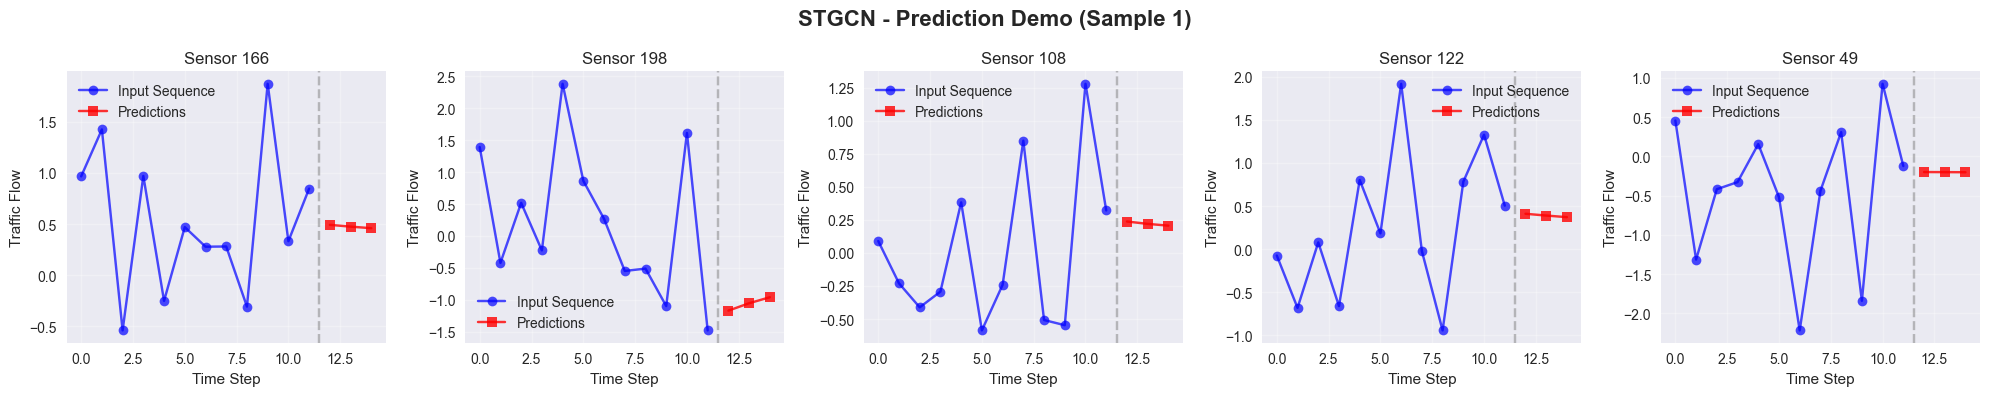


Model loading and prediction demo completed!
The model STGCN is now loaded and ready for predictions


In [45]:
def demo_model_loading_and_prediction():
    """Demonstrate loading a specific model and making predictions"""
    if not available_models:
        print("No trained models available for demo")
        print("This means the training notebook hasn't been run yet.")
        print("   Run 'traffic_pred_gnn.ipynb' first to train models.")
        return None, None
    
    # Select best performing model
    best_model_name = min(available_models.keys(), 
                         key=lambda x: available_models[x]['history']['test_loss'] 
                         if available_models[x]['history'] else float('inf'))
    
    print(f"Loading best model: {best_model_name}")
    
    # Load the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model, config = load_trained_model(best_model_name, available_models, device)
    
    if model is None:
        print("Failed to load model")
        return None, None
    
    # Generate dummy input data for demonstration
    num_nodes = config['num_nodes']
    seq_length = config['seq_length']
    pred_length = config['pred_length']
    
    print(f"Model Configuration:")
    print(f"   Nodes: {num_nodes}")
    print(f"   Sequence Length: {seq_length}")
    print(f"   Prediction Length: {pred_length}")
    
    # Create dummy input (in practice, this would be real traffic data)
    dummy_input = torch.randn(5, seq_length, num_nodes)  # 5 samples for demo
    
    print(f"\nMaking predictions with dummy data...")
    print(f"   Input shape: {dummy_input.shape}")
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        dummy_input = dummy_input.to(device)
        edge_index_device = edge_index.to(device)
        edge_weight_device = edge_weight.to(device)
        
        predictions = model(dummy_input, edge_index_device, edge_weight_device)
        
    print(f"   Output shape: {predictions.shape}")
    print(f"   Prediction successful!")
    
    # Visualize a sample prediction
    sample_idx = 0
    input_sample = dummy_input[sample_idx].cpu().numpy()
    pred_sample = predictions[sample_idx].cpu().numpy()
    
    # Plot for a few sensors
    n_sensors_plot = 5
    sensor_indices = np.random.choice(num_nodes, n_sensors_plot, replace=False)
    
    fig, axes = plt.subplots(1, n_sensors_plot, figsize=(20, 4))
    fig.suptitle(f'{best_model_name} - Prediction Demo (Sample {sample_idx+1})', 
                 fontsize=16, fontweight='bold')
    
    for i, sensor_idx in enumerate(sensor_indices):
        # Plot input sequence
        axes[i].plot(range(seq_length), input_sample[:, sensor_idx], 
                    'b-o', label='Input Sequence', alpha=0.7)
        
        # Plot predictions
        pred_x = range(seq_length, seq_length + pred_length)
        axes[i].plot(pred_x, pred_sample[:, sensor_idx], 
                    'r-s', label='Predictions', alpha=0.8)
        
        axes[i].axvline(seq_length - 0.5, color='gray', linestyle='--', alpha=0.5)
        axes[i].set_title(f'Sensor {sensor_idx}')
        axes[i].set_xlabel('Time Step')
        axes[i].set_ylabel('Traffic Flow')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nModel loading and prediction demo completed!")
    print(f"The model {best_model_name} is now loaded and ready for predictions")
    
    return model, config

# Safe model loading with error handling
try:
    loaded_model, model_config = demo_model_loading_and_prediction()
except Exception as e:
    print(f"Error in model demo: {e}")
    loaded_model, model_config = None, None

## 13. Export und Summary

In [46]:
def create_evaluation_summary():
    """Create and save evaluation summary with enhanced support for all experiment types"""
    print("Creating Evaluation Summary...")
    
    # Enhanced experiment type detection
    experiment_type = detect_experiment_type(os.path.basename(EXPERIMENT_DIR)) if EXPERIMENT_DIR else 'UNKNOWN'
    
    summary = {
        'evaluation_timestamp': datetime.now().isoformat(),
        'experiment_directory': EXPERIMENT_DIR,
        'experiment_type': experiment_type,
        'available_models': len(available_models),
        'csv_categories_loaded': len(csv_data),
        'dataset_info': dataset_info
    }
    
    # Enhanced model performance summary with dataset grouping
    if available_models:
        model_summary_detailed = {}
        architecture_summary = {}
        
        for model_name, info in available_models.items():
            if info['history']:
                arch = extract_base_architecture(model_name)
                dataset = info['dataset']
                
                # Individual model summary
                model_summary_detailed[model_name] = {
                    'test_loss': info['history']['test_loss'],
                    'test_mae': info['history']['test_mae'],
                    'architecture': arch,
                    'dataset': dataset,
                    'experiment_type': info['experiment_type']
                }
                
                # Architecture summary
                if arch not in architecture_summary:
                    architecture_summary[arch] = {}
                if dataset not in architecture_summary[arch]:
                    architecture_summary[arch][dataset] = []
                
                architecture_summary[arch][dataset].append({
                    'model_name': model_name,
                    'test_loss': info['history']['test_loss'],
                    'test_mae': info['history']['test_mae']
                })
        
        summary['model_performance'] = model_summary_detailed
        summary['architecture_summary'] = architecture_summary
        
        # Overall best model
        if model_summary_detailed:
            best_model = min(model_summary_detailed.keys(), 
                           key=lambda x: model_summary_detailed[x]['test_loss'])
            summary['best_model'] = {
                'name': best_model,
                'test_loss': model_summary_detailed[best_model]['test_loss'],
                'test_mae': model_summary_detailed[best_model]['test_mae'],
                'architecture': model_summary_detailed[best_model]['architecture'],
                'dataset': model_summary_detailed[best_model]['dataset']
            }
    
    # Enhanced CSV data summary
    csv_summary = {}
    for category, data in csv_data.items():
        if isinstance(data, dict):
            csv_summary[category] = {
                'type': 'dictionary',
                'keys': list(data.keys()),
                'count': len(data)
            }
        else:
            csv_summary[category] = {
                'type': 'dataframe',
                'shape': data.shape if hasattr(data, 'shape') else 'unknown',
                'columns': list(data.columns) if hasattr(data, 'columns') else 'unknown'
            }
    
    summary['csv_data_summary'] = csv_summary
    
    # Experiment-specific insights
    if experiment_type == 'ALL':
        all_experiment_insights = {
            'components_available': [],
            'completeness_score': 0
        }
        
        # Check completeness
        expected_components = [
            ('training_history', 'Model Training Results'),
            ('hyperparameter_results', 'Hyperparameter Tuning'),
            ('predictions', 'Prediction Analysis'),
            ('metrics', 'Detailed Metrics')
        ]
        
        available_components = 0
        for component_key, component_name in expected_components:
            if component_key in csv_data and csv_data[component_key]:
                all_experiment_insights['components_available'].append(component_name)
                available_components += 1
        
        all_experiment_insights['completeness_score'] = available_components / len(expected_components)
        summary['all_experiment_insights'] = all_experiment_insights
    
    # Save summary with error handling
    if EXPERIMENT_DIR:
        try:
            summary_file = os.path.join(EXPERIMENT_DIR, 'evaluation_summary.json')
            with open(summary_file, 'w') as f:
                json.dump(summary, f, indent=2, default=str)  # default=str handles datetime
            print(f"Evaluation summary saved to: {summary_file}")
        except Exception as e:
            print(f"Could not save evaluation summary: {e}")
    
    # Enhanced print summary with backward compatibility
    print("\n" + "="*60)
    print("TRAFFIC GNN MODEL EVALUATION SUMMARY")
    print("="*60)
    
    print(f"Experiment Type: {experiment_type}")
    print(f"Results Directory: {EXPERIMENT_DIR}")
    print(f"Evaluation Time: {summary['evaluation_timestamp']}")
    
    # Best model summary
    if 'best_model' in summary:
        best = summary['best_model']
        print(f"\nBest Overall Model: {best['name']}")
        print(f"   Test Loss: {best['test_loss']:.4f}")
        print(f"   Test MAE: {best['test_mae']:.4f}")
        print(f"   Architecture: {best['architecture']}")
        print(f"   Dataset: {best['dataset']}")
    
    # Dataset summary
    if dataset_info:
        print(f"\nDataset Information:")
        print(f"   Sensors: {dataset_info['shape'][1]}")
        print(f"   Timesteps: {dataset_info['shape'][0]}")
        print(f"   Sequence: {dataset_info['sequence_length']} → {dataset_info['prediction_length']}")
    
    # Architecture performance summary
    if 'architecture_summary' in summary:
        print(f"\nArchitecture Performance:")
        for arch, datasets in summary['architecture_summary'].items():
            print(f"   {arch}:")
            for dataset, models in datasets.items():
                if models:
                    avg_mae = sum(m['test_mae'] for m in models) / len(models)
                    best_mae = min(m['test_mae'] for m in models)
                    print(f"      {dataset}: {len(models)} models, Avg MAE: {avg_mae:.4f}, Best: {best_mae:.4f}")
    
    # Models evaluated
    print(f"\nModels Evaluated: {summary['available_models']}")
    if 'model_performance' in summary:
        print(f"   Performance Summary:")
        for model_name, perf in summary['model_performance'].items():
            arch = perf['architecture']
            dataset = perf['dataset']
            print(f"      {model_name[:40]:<40} [{arch}] [{dataset}] - Loss: {perf['test_loss']:.4f}, MAE: {perf['test_mae']:.4f}")
    
    # CSV data summary
    print(f"\nCSV Data Categories: {summary['csv_categories_loaded']}")
    for category, info in csv_summary.items():
        if info['type'] == 'dictionary':
            print(f"   {category}: {info['count']} items")
        else:
            shape_str = f"{info['shape']}" if info['shape'] != 'unknown' else 'unknown shape'
            print(f"   {category}: {shape_str}")
    
    # Experiment completeness (for 'all' experiments)
    if experiment_type == 'ALL' and 'all_experiment_insights' in summary:
        insights = summary['all_experiment_insights']
        completeness = insights['completeness_score'] * 100
        print(f"\nExperiment Completeness: {completeness:.1f}%")
        print(f"   Available Components:")
        for component in insights['components_available']:
            print(f"      {component}")
    
    # Status and recommendations
    print(f"\nEVALUATION COMPLETE!")
    
    if summary['available_models'] > 0:
        print(f"   {summary['available_models']} trained models analyzed")
        print(f"   Comprehensive visualizations created")
        print(f"   CSV data analysis completed")
        print(f"   Best performing model identified")
        
        if experiment_type == 'ALL':
            print(f"   Comprehensive experiment analysis available")
        
        print(f"   Results saved and summarized")
    else:
        print(f"   No models found for evaluation")
        print(f"   Run training script to generate models:")
        print(f"      python traffic_gnn_training.py --experiment all")
        print(f"      python traffic_gnn_training.py --experiment comparison")
    
    return summary

evaluation_summary = create_evaluation_summary()

Creating Evaluation Summary...
Evaluation summary saved to: /Volumes/DATA SSD/Experimente/gsp/traffic_gnn_results/traffic_gnn_all_20250728_141512/evaluation_summary.json

TRAFFIC GNN MODEL EVALUATION SUMMARY
Experiment Type: ALL
Results Directory: /Volumes/DATA SSD/Experimente/gsp/traffic_gnn_results/traffic_gnn_all_20250728_141512
Evaluation Time: 2025-07-30T21:24:32.416609

Best Overall Model: STGCN
   Test Loss: 0.1669
   Test MAE: 0.1949
   Architecture: STGCN
   Dataset: UNKNOWN

Dataset Information:
   Sensors: 207
   Timesteps: 34272
   Sequence: 12 → 3

Architecture Performance:
   GraphTransformer:
      UNKNOWN: 1 models, Avg MAE: 0.1857, Best: 0.1857
   STGCN:
      UNKNOWN: 1 models, Avg MAE: 0.1949, Best: 0.1949
   GraphAttention:
      UNKNOWN: 1 models, Avg MAE: 0.2861, Best: 0.2861
   GraphWaveNet:
      UNKNOWN: 1 models, Avg MAE: 0.2402, Best: 0.2402

Models Evaluated: 4
   Performance Summary:
      GraphTransformer                         [GraphTransformer] [UNKNOWN